In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import time
import math
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import os
from sklearn.ensemble import RandomForestRegressor
import joblib
from torch.optim.lr_scheduler import StepLR
from LSTM.config import Config
from LSTM.EarlyStopping import EarlyStopping
from LSTM.model1 import LSTM,BiLSTM

In [57]:
import torch
from torch import nn 
from torch.utils.data import Dataset,DataLoader


In [86]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [87]:
def DataLoader_tolist(load):
    l1 = []
    for l in load:
        l1.append(l)
    return l1

In [108]:
data = pd.read_excel("../data/碳排放总量.xlsx",index_col=0).iloc[:,1]
data

2000    736.250475
2001    733.348364
2002    722.529652
2003    704.345102
2004    746.373703
2005    763.779886
2006    771.871754
2007    787.139241
2008    799.857388
2009    808.907265
2010    813.788299
2011    817.210283
2012    826.616856
2013    817.879782
2014    817.902390
2015    809.276893
2016    813.388081
2017    789.374558
2018    785.563552
2019    748.046697
2020    760.929422
Name: 南昌市, dtype: float64

In [109]:
class MyDataset(Dataset):
            def __init__(self, data):
                self.data = data

            def __getitem__(self, item):
                return self.data[item]

            def __len__(self):
                return len(self.data)


class Data_create():
    def __init__(self,data,train_B,Val_B,Test_B,t,Dtr_p,Val_p1,Val_p2,Dte_p):
        self.data = data
        self.train_B = train_B
        self.Val_B = Val_B
        self.Test_B = Test_B
        self.t = t
        self.Dtr_p = Dtr_p
        self.Val_p1 = Val_p1
        self.Val_p2 = Val_p2
        self.Dte_p = Dte_p
        
        
    
    def nn_seq_us(self,):
        print('data processing...')
        dataset = self.data
        # split
        # train = dataset[:int(len(dataset) * 0.8)]
        # val = dataset[int(len(dataset) * 0.8):int(len(dataset) * 0.9)]
        # test = dataset[int(len(dataset) * 0.9):len(dataset)]
        m, n = np.max(dataset), np.min(dataset)
        print(m,n)
        def process(data, batch_size, shuffle):
            load1 = data.values
            load = (load1 - n) / (m - n)
            # load = load1
            # print(load)
            seq = []
            for i in range(len(data) - self.t):
                train_seq = []
                train_label = []
                for j in range(i, i + self.t):
                    x = [load[j]]
                    train_seq.append(x)
                # for c in range(2, 8):
                #     train_seq.append(data[i + 24][c])
                train_label.append(load[i + self.t])
                train_seq = torch.FloatTensor(train_seq)
                train_label = torch.FloatTensor(train_label).view(-1)
                seq.append((train_seq, train_label))

            print(len(seq))
            
            # seq = MyDataset(seq)
            # seq = DataLoader(dataset=seq, batch_size=batch_size, shuffle=shuffle, num_workers=0, drop_last=True)

            return seq

    
        seq = process(dataset,self.train_B,False)
        Dtr = DataLoader(dataset=MyDataset(seq[:int(len(seq) * self.Dtr_p)])
                         , batch_size=self.train_B, shuffle=False, num_workers=0, drop_last=True)
        
        
        Val = DataLoader(dataset=MyDataset(seq[int(len(seq) * self.Val_p1):int(len(seq) * self.Val_p2)])
                         , batch_size=self.Val_B, shuffle=False, num_workers=0, drop_last=True)
        
        Dte = DataLoader(dataset=MyDataset(seq[int(len(seq) * self.Dte_p):len(seq)])
                         , batch_size=self.Test_B, shuffle=False, num_workers=0, drop_last=True)
        return Dtr, Val, Dte, m, n

In [110]:
Dtr, Val, Dte, m, n = Data_create(data= data
                ,train_B=4
                ,Val_B=4
                ,Test_B=1
                ,t=8
                ,Dtr_p=1
                ,Val_p1=0
                ,Val_p2=1
                ,Dte_p=0).nn_seq_us()

data processing...
826.6168562743735 704.3451021020015
13


In [111]:
len(list(Dtr)),len(list(Val)),len(list(Dte))

(3, 3, 13)

In [112]:
for i in Dtr:
    print(i[0].shape)

torch.Size([4, 8, 1])
torch.Size([4, 8, 1])
torch.Size([4, 8, 1])


In [113]:
def get_val_loss(args, model, Val):
    model.eval()
    loss_function1 = nn.MSELoss().to(device)
    loss_sum = 0
    for (seq, label) in Val:
        seq = seq.to(device)
        label = label.to(device)
        y_pred = model(seq)
        loss = loss_function1(y_pred, label)
        loss_sum = loss_sum+loss
    return loss_sum


def train(args, Dtr, Val, path):
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    early_stopping = EarlyStopping(patience=3)
    if args.bidirectional:
        model = BiLSTM(input_size, hidden_size, num_layers, output_size, batch_size=args.batch_size).to(device)
    else:
        model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=args.batch_size).to(device)

    loss_function = nn.MSELoss().to(device)
    print(args.optimizer,args.weight_decay)
    if args.optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=args.lr,
                                     weight_decay=args.weight_decay
                                     )
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=args.lr,
                                    momentum=0.9, weight_decay=args.weight_decay)
    # scheduler = StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)
    # training
    min_epochs = 10
    best_model = None
    min_val_loss = 5
    for epoch in tqdm(range(args.epochs)):
        train_loss = 0
        for (seq, label) in Dtr:
            seq = seq.to(device)
            label = label.to(device)
            y_pred = model(seq)
            loss = loss_function(y_pred, label)
            # train_loss.append(loss.item())
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            with torch.no_grad():
                train_loss+=loss

        # validation
        with torch.no_grad():
            val_loss = get_val_loss(args, model, Val)
            # if epoch > min_epochs and val_loss < min_val_loss:
            #     min_val_loss = val_loss
            #     best_model = copy.deepcopy(model)
            early_stopping(val_loss,model,path)
            if early_stopping.early_stop:
                    print("Early stopping")
                    break
            # if train_loss < 0.01:
            #     break

            print('epoch {:03d} train_loss {:.8f} val_loss {:.8f}'.format(epoch, train_loss, val_loss))
            # print('epoch {:03d} train_loss {:.8f} '.format(epoch, np.mean(train_loss)))
        model.train()

    # state = {'models': best_model.state_dict()}
    # torch.save(state, path)

In [123]:
args = Config(
    input_size=1
    ,hidden_size= 64
    ,num_layers=2
    ,output_size=1
    ,bidirectional=False
    ,optimizer="adam"
    ,epochs=500
    ,batch_size=4
    ,lr=0.001
    ,weight_decay=0.055
)
train(args,Dtr, Val, "./model")


adam 0.055


  0%|          | 1/500 [00:00<01:13,  6.82it/s]

epoch 000 train_loss 2.47457123 val_loss 2.32137299
epoch 001 train_loss 2.24602675 val_loss 2.08024454


  1%|          | 4/500 [00:00<00:30, 16.14it/s]

epoch 002 train_loss 2.00388670 val_loss 1.85334325
epoch 003 train_loss 1.77265584 val_loss 1.61419368
epoch 004 train_loss 1.55504894 val_loss 1.38282835
epoch 005 train_loss 1.29942155 val_loss 1.13517487


  1%|▏         | 7/500 [00:00<00:24, 20.24it/s]

epoch 006 train_loss 1.04746306 val_loss 0.86111629
epoch 007 train_loss 0.79310215 val_loss 0.58300084


  2%|▏         | 10/500 [00:00<00:21, 22.52it/s]

epoch 008 train_loss 0.53728729 val_loss 0.36483806
epoch 009 train_loss 0.32486546 val_loss 0.19845563
epoch 010 train_loss 0.18434516 val_loss 0.12059500
epoch 011 train_loss 0.12559801 val_loss 0.09944238

  3%|▎         | 14/500 [00:00<00:18, 25.65it/s]


epoch 012 train_loss 0.10549060 val_loss 0.09571591
EarlyStopping counter: 1 out of 3
epoch 013 train_loss 0.09406088 val_loss 0.09839240
EarlyStopping counter: 2 out of 3


  3%|▎         | 15/500 [00:00<00:22, 21.55it/s]

epoch 014 train_loss 0.08287524 val_loss 0.09643391
EarlyStopping counter: 3 out of 3
Early stopping


In [125]:
from itertools import chain
def test(args, Dte, path, m, n):
    pred = []
    y = []
    print('loading models...')
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    if args.bidirectional:
        model = BiLSTM(input_size, hidden_size, num_layers, output_size, batch_size=1).to(device)
    else:
        model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=1).to(device)
    # models = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=args.batch_size).to(device)
    model.load_state_dict(torch.load(path))
    model.eval()
    print('predicting...')
    for (seq, target) in tqdm(Dte):
        target = list(chain.from_iterable(target.data.tolist()))
        y.extend(target)
        seq = seq.to(device)
        with torch.no_grad():
            y_pred = model(seq)
            y_pred = list(chain.from_iterable(y_pred.data.tolist()))
            pred.extend(y_pred)

    y, pred = np.array(y), np.array(pred)
    
    y = (m - n) * y + n
    pred = (m - n) * pred + n
    
    
    # print('mape:', get_mape(y, pred))
    # plot
    # x = [i for i in range(1, 151)]
    # x_smooth = np.linspace(np.min(x), np.max(x), 900)
    # y_smooth = make_interp_spline(x, y[150:300])(x_smooth)
    # plt.plot(x_smooth, y_smooth, c='green', marker='*', ms=1, alpha=0.75, label='true')

    # y_smooth = make_interp_spline(x, pred[150:300])(x_smooth)
    plt.plot(y, c='black', marker='o', ms=1, alpha=0.75, label='true')
    plt.plot(pred, c='red', marker='o', ms=1, alpha=0.75, label='pred')
    plt.grid(axis='y')
    plt.legend()
    plt.show()
    
    return pred

loading models...
predicting...


100%|██████████| 13/13 [00:00<00:00, 592.47it/s]


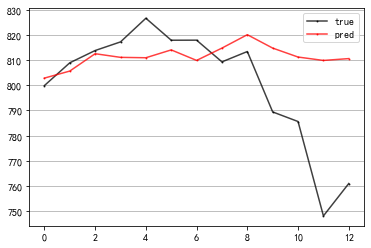

array([802.82742434, 805.62106145, 812.51859509, 811.07088468,
       810.91710863, 814.03403985, 809.85232244, 814.75996484,
       820.07670984, 814.75212299, 811.19448856, 809.84445873,
       810.58018603])

In [126]:

test(args =args
     ,Dte= Dte
     ,path="./model/checkpoint.pth"
     ,m=m
     ,n=n)


In [128]:
def predict_next(path, sample, args,SEQ_LEN,m,n,epoch=35):
    
    print('loading models...')
    input_size, hidden_size, num_layers = args.input_size, args.hidden_size, args.num_layers
    output_size = args.output_size
    if args.bidirectional:
        model = BiLSTM(input_size, hidden_size, num_layers, output_size, batch_size=1).to(device)
    else:
        model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=1).to(device)
    # models = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=args.batch_size).to(device)
    model.load_state_dict(torch.load(path))
    model.eval()
    print('predicting...')
    
    temp1 = sample.detach().numpy().tolist()
    for i in range(epoch):
        sample = sample.reshape(1, SEQ_LEN, 1)
        # print(sample)
        pred = model(sample)
        # print(pred.detach().numpy().reshape(1,).tolist())
        # pred = pred.detach().numpy()
        temp1.append(pred.detach().numpy().reshape(1,).tolist())
        sample = torch.tensor(np.array(temp1[i+1 : i+SEQ_LEN+1]),dtype=torch.float32)
    return [(m - n) * p[0] + n for p in  temp1]

loading models...
predicting...


,prediction
2012,826.616856
2013,817.879782
2014,817.902389
2015,809.276894
2016,813.388078
2017,789.374556
2018,785.563548
2019,748.046696
2020,805.491948
2021,799.897444


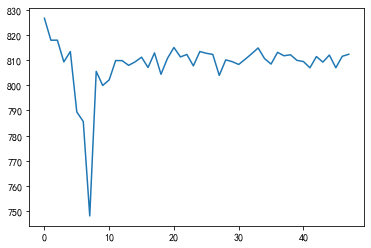

In [130]:
list = predict_next(path="./model/checkpoint.pth"
             ,sample=DataLoader_tolist(Dte)[-1][0][-1]
             ,args=args
             ,SEQ_LEN=8
             ,m=m
             ,n=n
             ,epoch=40)
plt.plot(list)
pd.DataFrame(list,index=range(2012,2012+48),columns=["prediction"])

In [ ]:
len(list)

48

In [ ]:
# plt.figure(figsize=(16,9))

# plt.xticks(range(2014,2014+22))
